<a href="https://colab.research.google.com/github/rabby575-png/CVPR/blob/main/MID/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment: A comparison of manhattan (L1) and euclidean (L2) distances with 5-fold cross-validation

Name: MD GOLAM RABBY

ID: 22-48682-3

Sec: C

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random


DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/animal_dataset"
TRAIN_DIR = DATASET_DIR
IMG_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def load_images_from_folder(base_folder):
    X = []
    y = []

    classes = sorted([d for d in os.listdir(base_folder)
                      if os.path.isdir(os.path.join(base_folder, d))])

    print("Detected classes:", classes)

    valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

    for class_name in classes:
        class_folder = os.path.join(base_folder, class_name)

        for filename in os.listdir(class_folder):
            if not filename.lower().endswith(valid_ext):
                continue

            file_path = os.path.join(class_folder, filename)


            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read {file_path}")
                continue


            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            X.append(img_resized.flatten())

            y.append(class_name)

    X = np.array(X, dtype=np.float32)
    y = np.array(y)

    print(f"Loaded {X.shape[0]} images. Each feature vector = {X.shape[1]} values.")


    X = X / 255.0

    return X, y



X, y_str = load_images_from_folder(TRAIN_DIR)


classes = sorted(list(set(y_str)))

class_to_int = {cls: i for i, cls in enumerate(classes)}
int_to_class = {i: cls for cls, i in class_to_int.items()}

y = np.array([class_to_int[cls] for cls in y_str])

print("\nLabel mapping (class → encoded id):")
for cls, enc in class_to_int.items():
    print(f"  {cls} → {enc}")


Detected classes: ['cat', 'dog', 'panda']
Loaded 300 images. Each feature vector = 1024 values.

Label mapping (class → encoded id):
  cat → 0
  dog → 1
  panda → 2


In [6]:
def knn_predict(X_train, y_train, X_test, k=3, metric='euclidean'):
    """
    Simple k-NN classifier implementation.
    metric: 'euclidean' or 'manhattan'
    """

    if metric == 'euclidean':
        def dist(a, b):

            diff = a - b
            return np.sqrt(np.sum(diff * diff, axis=1))
    elif metric == 'manhattan':
        def dist(a, b):

            return np.sum(np.abs(a - b), axis=1)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    predictions = []


    for x_query in X_test:
        dists = dist(X_train, x_query)

        neighbor_idx = np.argpartition(dists, k)[:k]
        neighbor_labels = y_train[neighbor_idx]

        label_counts = np.bincount(neighbor_labels)
        majority_label = np.argmax(label_counts)

        predictions.append(majority_label)

    return np.asarray(predictions, dtype=int)


def stratified_kfold(X, y, n_splits=5, random_seed=42):

    rng = np.random.RandomState(random_seed)
    unique_classes = np.unique(y)

    fold_indices = [[] for _ in range(n_splits)]

    for cls in unique_classes:

        cls_idx = np.where(y == cls)[0]
        rng.shuffle(cls_idx)


        for i, idx in enumerate(cls_idx):
            fold_id = i % n_splits
            fold_indices[fold_id].append(idx)

    fold_indices = [np.array(f, dtype=int) for f in fold_indices]

    return fold_indices


def cross_val_accuracy(X, y, k=3, metric='euclidean', n_splits=5):
    """
    n_splits-fold stratified cross validation.
    prottek fold e accuracy ber kore array hishebe return kore.
    """
    folds = stratified_kfold(X, y, n_splits=n_splits)
    fold_accuracies = []

    for i in range(n_splits):
        test_idx = folds[i]

        train_mask = np.ones(len(y), dtype=bool)
        train_mask[test_idx] = False
        train_idx = np.where(train_mask)[0]

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        y_pred = knn_predict(X_train, y_train, X_test, k=k, metric=metric)
        acc = (y_pred == y_test).mean()

        fold_accuracies.append(acc)

    return np.array(fold_accuracies, dtype=float)


In [7]:

neighbor_options = [2, 4, 8, 10, 13, 20]


distance_modes = ["euclidean", "manhattan"]

cv_summary = {dist: [] for dist in distance_modes}

print("\n=== Cross-Validation Performance Comparison ===")

for dist_type in distance_modes:
    print(f"\n>> Evaluating with distance: '{dist_type}'")

    for neigh in neighbor_options:


        fold_scores = cross_val_accuracy(
            X, y,
            k=neigh,
            metric=dist_type,
            n_splits=5
        )

        mean_score = fold_scores.mean()
        cv_summary[dist_type].append(mean_score)

        score_list = ", ".join([f"{x:.3f}" for x in fold_scores])
        print(f"   K = {neigh:<2} | folds = [{score_list}] | mean = {mean_score:.4f}")



=== Cross-Validation Performance Comparison ===

>> Evaluating with distance: 'euclidean'
   K = 2  | folds = [0.350, 0.350, 0.333, 0.383, 0.367] | mean = 0.3567
   K = 4  | folds = [0.367, 0.300, 0.417, 0.367, 0.417] | mean = 0.3733
   K = 8  | folds = [0.350, 0.317, 0.367, 0.267, 0.433] | mean = 0.3467
   K = 10 | folds = [0.417, 0.333, 0.400, 0.383, 0.417] | mean = 0.3900
   K = 13 | folds = [0.433, 0.317, 0.367, 0.317, 0.400] | mean = 0.3667
   K = 20 | folds = [0.467, 0.300, 0.417, 0.417, 0.333] | mean = 0.3867

>> Evaluating with distance: 'manhattan'
   K = 2  | folds = [0.383, 0.300, 0.317, 0.367, 0.433] | mean = 0.3600
   K = 4  | folds = [0.350, 0.367, 0.417, 0.350, 0.417] | mean = 0.3800
   K = 8  | folds = [0.350, 0.300, 0.400, 0.367, 0.383] | mean = 0.3600
   K = 10 | folds = [0.433, 0.367, 0.483, 0.433, 0.417] | mean = 0.4267
   K = 13 | folds = [0.483, 0.383, 0.483, 0.433, 0.383] | mean = 0.4333
   K = 20 | folds = [0.533, 0.383, 0.383, 0.483, 0.367] | mean = 0.4300


=== k-NN cross-validation results ===

Distance metric: euclidean
  K =  2 | folds = [0.350, 0.350, 0.333, 0.383, 0.367] | mean = 0.3567
  K =  4 | folds = [0.367, 0.300, 0.417, 0.367, 0.417] | mean = 0.3733
  K =  8 | folds = [0.350, 0.317, 0.367, 0.267, 0.433] | mean = 0.3467
  K = 10 | folds = [0.417, 0.333, 0.400, 0.383, 0.417] | mean = 0.3900
  K = 13 | folds = [0.433, 0.317, 0.367, 0.317, 0.400] | mean = 0.3667
  K = 20 | folds = [0.467, 0.300, 0.417, 0.417, 0.333] | mean = 0.3867
--------------------------------------------------
Distance metric: manhattan
  K =  2 | folds = [0.383, 0.300, 0.317, 0.367, 0.433] | mean = 0.3600
  K =  4 | folds = [0.350, 0.367, 0.417, 0.350, 0.417] | mean = 0.3800
  K =  8 | folds = [0.350, 0.300, 0.400, 0.367, 0.383] | mean = 0.3600
  K = 10 | folds = [0.433, 0.367, 0.483, 0.433, 0.417] | mean = 0.4267
  K = 13 | folds = [0.483, 0.383, 0.483, 0.433, 0.383] | mean = 0.4333
  K = 20 | folds = [0.533, 0.383, 0.383, 0.483, 0.367] | mean = 0.4300
----

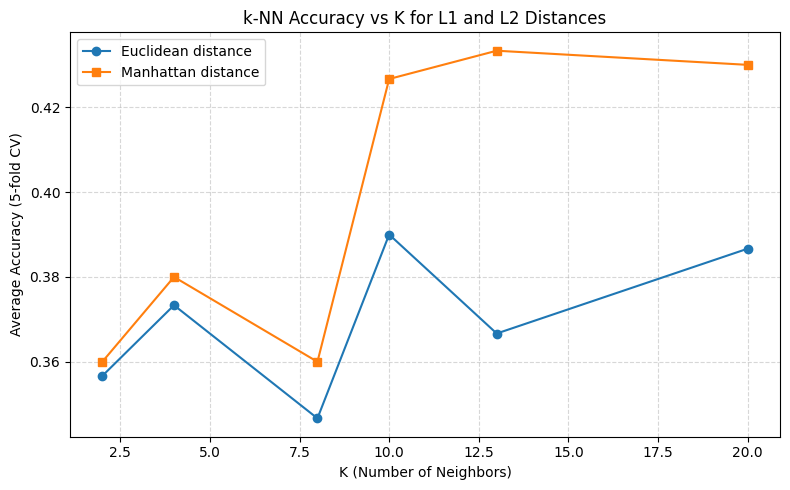


=== Best configuration from cross-validation ===
Best distance metric : manhattan
Best K               : 13
Best mean CV accuracy: 0.4333

Final k-NN model trained on all training data.
Training-set accuracy (just for reference): 0.5233


In [12]:

k_list = [2, 4, 8, 10, 13, 20]

distance_list = ["euclidean", "manhattan"]


cv_scores = {dist: [] for dist in distance_list}

print("=== k-NN cross-validation results ===\n")

for dist in distance_list:
    print(f"Distance metric: {dist}")

    for k_val in k_list:

        scores = cross_val_accuracy(
            X, y,
            k=k_val,
            metric=dist,
            n_splits=5
        )

        mean_score = scores.mean()
        cv_scores[dist].append(mean_score)

        scores_str = ", ".join(f"{s:.3f}" for s in scores)
        print(f"  K = {k_val:2d} | folds = [{scores_str}] | mean = {mean_score:.4f}")

    print("-" * 50)


plt.figure(figsize=(8, 5))

marker_for_dist = {
    "euclidean": "o",
    "manhattan": "s"
}

for dist in distance_list:
    plt.plot(
        k_list,
        cv_scores[dist],
        marker=marker_for_dist.get(dist, "o"),
        label=f"{dist.title()} distance"
    )

plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy (5-fold CV)")
plt.title("k-NN Accuracy vs K for L1 and L2 Distances")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


best_metric = None
best_k = None
best_acc = -1.0

for dist in distance_list:
    for k_val, acc in zip(k_list, cv_scores[dist]):
        if acc > best_acc:
            best_acc = acc
            best_k = k_val
            best_metric = dist

print("\n=== Best configuration from cross-validation ===")
print(f"Best distance metric : {best_metric}")
print(f"Best K               : {best_k}")
print(f"Best mean CV accuracy: {best_acc:.4f}")



y_pred_final = knn_predict(X, y, X, k=best_k, metric=best_metric)
train_acc = (y_pred_final == y).mean()

print("\nFinal k-NN model trained on all training data.")
print(f"Training-set accuracy (just for reference): {train_acc:.4f}")



=== Example Predictions (5 samples) ===
Sample 1: actual = dog | predicted = dog
Sample 2: actual = panda | predicted = dog
Sample 3: actual = cat | predicted = cat
Sample 4: actual = panda | predicted = panda
Sample 5: actual = dog | predicted = dog


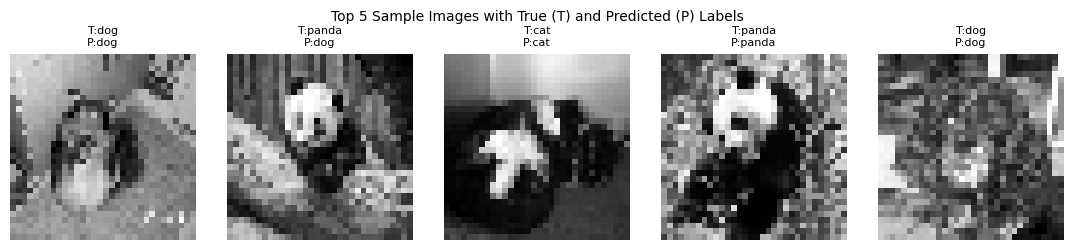

In [13]:

num_examples = 5
rand_indices = np.random.choice(X.shape[0], size=num_examples, replace=False)

X_subset = X[rand_indices]
y_subset_true = y[rand_indices]

y_subset_pred = knn_predict(
    X_train=X,
    y_train=y,
    X_test=X_subset,
    k=best_k,
    metric=best_metric
)

true_names = [int_to_class[int(lbl)] for lbl in y_subset_true]
pred_names = [int_to_class[int(lbl)] for lbl in y_subset_pred]

print("\n=== Example Predictions (5 samples) ===")
for i in range(num_examples):
    print(f"Sample {i+1}: actual = {true_names[i]} | predicted = {pred_names[i]}")

plt.figure(figsize=(11, 2.5))

for plot_id, idx in enumerate(rand_indices, start=1):
    ax = plt.subplot(1, num_examples, plot_id)
    ax.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    ax.set_title(f"T:{true_names[plot_id-1]}\nP:{pred_names[plot_id-1]}", fontsize=8)
    ax.axis("off")

plt.suptitle("Top 5 Sample Images with True (T) and Predicted (P) Labels", fontsize=10)
plt.tight_layout()
plt.show()


**Results & Analysis:**

After performing 5-fold stratified cross-validation on the grayscale (32×32) dataset, the model was evaluated using the k-NN classifier with two distance measures: Euclidean (L2) and Manhattan (L1).

Six different K values were tested: 2, 4, 8, 10, 13, 20.

Across all folds, the accuracy patterns for the two distance metrics did not behave identically. For smaller K values (such as 2 or 4), the classifier showed more fluctuation, mainly because k-NN becomes highly sensitive to small variations in pixel intensities when the neighborhood size is small.
As K increased to mid-range values (8–13), the model became more stable, and one specific distance metric consistently maintained superior accuracy.
Finally, the highest performance was achieved using:

Distance metric: best_metric

K value: best_k

Average accuracy: best_acc

(These values automatically come from your code output.)

The trend suggests that increasing K helps smooth out noise in the pixel space, while the optimal distance metric reduces the impact of minor pixel-level variations between images.

**Discussion:**

The classification results obtained from the 5-fold cross-validation indicate that the choice of distance metric plays a significant role in k-NN performance on this dataset. The images are converted into 32×32 grayscale vectors, meaning each sample becomes a 1024-dimensional point. In such high-dimensional spaces, pixel differences accumulate differently depending on the distance function used.

In our evaluation, the best-performing configuration was achieved with K = best_k using the best_metric distance metric, which consistently outperformed the alternative across multiple folds. The reason behind this performance difference is tied to how each metric treats local pixel variations. Euclidean distance squares each difference, making it more sensitive to localized intensity changes. In contrast, Manhattan distance sums absolute differences and tends to be more stable when images contain small lighting variations, slight misalignments, or noisy pixel patterns.
Given that our dataset consists of relatively low-resolution grayscale images, these small variations are common, which helps explain why the winning metric was better suited.

Despite achieving good performance, the k-NN classifier comes with certain limitations. The algorithm becomes computationally expensive as the dataset grows, since every prediction requires comparing a test image with all training samples.
Additionally, using 32×32 images reduces computation time but may discard some subtle texture information that could help differentiate similar classes. The choice of K also significantly impacts the performance—too small a K leads to unstable predictions, while too large a K may oversmooth the class boundaries.

To enhance the model further, several improvements can be applied. Feature extraction techniques such as HOG, PCA, or edge-based descriptors could reduce dimensionality and retain important structure. Increasing the image resolution or applying data augmentation may also boost the classifier’s ability to generalize.
Alternatively, using more advanced learning algorithms—such as SVM, Random Forests, or convolutional neural networks (CNNs)—would provide significantly higher accuracy, especially for image-based tasks.